# M3. Computer Vision (24.05.2024), Dr. Aygul Zagidullina

**A walkthrough of the full process of loading data, comparing different vision models, seeing the benefits of transfer learning and data augmentation, saving/ loading models, then predicting on some data in the wild.**

## Dataset

This Dataset contains about 5000 pictures of cats and dogs (4000 for training and 1000 for testing). Each categories will be in a separated folder, `cat-and-dog/training_set/` and `cat-and-dog/test_set` and then in sub folders `cats` and `dogs`.

In [20]:
import numpy as np
np.object = object   
np.bool = bool   
np.int = int  
np.float = float    
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
#from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils.class_weight import compute_class_weight
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow import keras
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
#from tensorflow.keras.datasets import cifar10
from tensorflow.keras import utils, layers, models, optimizers, callbacks
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Sequential, Model, load_model##
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
import h5py
import scipy as sp
import imageio
from PIL import Image
from io import BytesIO
import zipfile


In [19]:
##%%capture
# Let's store the location of our data in 2 variables that we can re use later

train_data_dir = "cat-and-dog-small/training_set/"
test_data_dir = "cat-and-dog-small/test_set/"

#!unzip cat-and-dog.zip


In [ ]:
!ls

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# import tensorflow as tf
import keras

# print(tf.__version__)
print(keras.__version__)

In [21]:
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

img = load_img(f"{train_data_dir}cats/cat.3.jpg")
x = img_to_array(img)/255  # We divide the pixel value by 255 to end up between 0 and 1

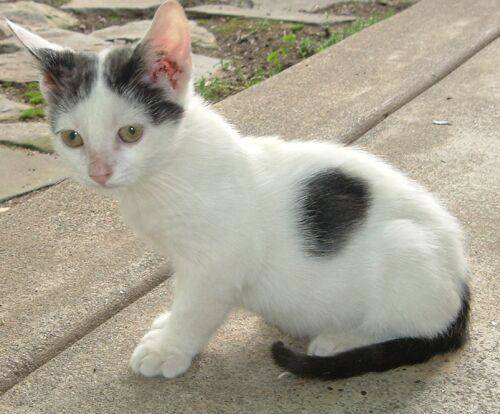

In [22]:
img

In [23]:
x.shape

(414, 500, 3)

### First ("weak") model

In [24]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers, optimizers, callbacks

In [25]:
from tensorflow.keras.utils import image_dataset_from_directory

In [26]:
model = Sequential()

model.add(layers.Conv2D(filters = 32, kernel_size = (3,3), input_shape = (150, 150, 3), activation="relu", padding = "same"))
model.add(layers.Conv2D(filters = 32, kernel_size = (3,3), activation="relu", padding = "same"))
model.add(layers.Conv2D(filters = 64, kernel_size = (3,3), activation="relu", padding = "same"))
model.add(layers.Conv2D(filters = 128, kernel_size = (3,3), activation="relu", padding = "same"))
model.add(layers.Flatten())

model.add(layers.Dense(64, activation="relu"))

model.add(layers.Dropout(0.5))

model.add(layers.Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 150, 150, 128)     73856     
_________________________________________________________________
flatten (Flatten)            (None, 2880000)           0         
_________________________________________________________________
dense (Dense)                (None, 64)                184320064 
_________________________________________________________________
dropout (Dropout)            (None, 64)                0

Here we didn't use any pooling layers which gave us a very high amount

---

of parameters ...

### First ("strong") model

This time with pooling layers

In [27]:

model = Sequential()

model.add(layers.Rescaling(1./255, input_shape = (150, 150, 3)))
model.add(layers.Conv2D(filters = 32, kernel_size = (3,3), activation="relu", padding = "same"))
model.add(layers.MaxPooling2D(pool_size=(2, 2), padding = "same") )


model.add(layers.Conv2D(filters = 32, kernel_size = (3,3), activation="relu", padding = "same"))
model.add(layers.MaxPooling2D(pool_size=(2, 2), padding = "same") )


model.add(layers.Conv2D(filters = 64, kernel_size = (3,3), activation="relu", padding = "same"))
model.add(layers.MaxPooling2D(pool_size=(2, 2), padding = "same") )

model.add(layers.Conv2D(filters = 128, kernel_size = (3,3), activation="relu", padding = "same"))
model.add(layers.MaxPooling2D(pool_size=(2, 2), padding = "same") )

model.add(layers.Flatten())

# Here we flatten our data to end up with just one dimension

model.add(layers.Dense(64, activation="relu"))

model.add(layers.Dropout(0.5))

model.add(layers.Dense(1, activation="sigmoid"))

# And we perform the prediction using sigmoid

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 38, 38, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 19, 19, 64)       

With pooling layers with drastically reduced the amount of parameters from 165,286,113 to 504,033

In [29]:

adam = optimizers.Adam(learning_rate = 0.001)
model.compile(loss='binary_crossentropy',
              optimizer= adam,
              metrics=['accuracy'])


In [30]:
batch_size = 64

Here, we'll create a `Tensorflow Datasets` object.
This will allow us to:


*   Grab images from our directory batch by batch, we won't load the FULL data at the same time
*   Reshape all the images to our desired input shape, 150x150 in this notebook



We have to specify different things:


*   Where the data is located (that's why we saved the folder name in a variable)
*   The target size to resize our images so they fit our model
*   The Batch size
*   The "label mode", here we say binary, and the classes will be infered based on the folders name. It will chose cat = 0 and dog = 1
*   Here the labels are inferred based on the folder structure








In [31]:
train_ds = image_dataset_from_directory(
  train_data_dir,
  labels = "inferred",
  label_mode = "binary",
  seed=123,
  image_size=(150, 150),
  batch_size=batch_size)

# We define a second one for the test data

val_ds = image_dataset_from_directory(
  test_data_dir,
  labels = "inferred",
  label_mode = "binary",
  seed=123,
  image_size=(150, 150),
  batch_size=batch_size)

Found 4004 files belonging to 2 classes.
Found 1012 files belonging to 2 classes.


In [32]:
class_names = train_ds.class_names
print(class_names)

['cats', 'dogs']


Here we'll create our callbacks. Those functions will be called at the end of every single epoch.
We'll use:


*   `ModelCheckpoint` to save the best version of our model after every epoch
*   `ReduceLROnPlateau` to reduce the `learning_rate` if the model doesn't get better after a few epochs
*   `EarlyStopping` to stop the training after a certain time if it's not improving



In [33]:
MODEL = "model_1"

modelCheckpoint = callbacks.ModelCheckpoint("{}.keras".format(MODEL), monitor="val_loss", verbose=0, save_best_only=True)

LRreducer = callbacks.ReduceLROnPlateau(monitor="val_loss", factor = 0.1, patience=3, verbose=1, min_lr=0)

EarlyStopper = callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True)


In [34]:
%%time
history = model.fit(
        train_ds,
        epochs=30,
        validation_data=val_ds,
        callbacks = [modelCheckpoint, LRreducer, EarlyStopper])


Epoch 1/30
63/63 [==============================] - 21s 326ms/step - loss: 0.6944 - accuracy: 0.5270 - val_loss: 0.6813 - val_accuracy: 0.5870
Epoch 2/30
63/63 [==============================] - 22s 352ms/step - loss: 0.6712 - accuracy: 0.5964 - val_loss: 0.6276 - val_accuracy: 0.6660
Epoch 3/30
63/63 [==============================] - 22s 343ms/step - loss: 0.6295 - accuracy: 0.6489 - val_loss: 0.5879 - val_accuracy: 0.6868
Epoch 4/30
63/63 [==============================] - 25s 403ms/step - loss: 0.5890 - accuracy: 0.6933 - val_loss: 0.5945 - val_accuracy: 0.6789
Epoch 5/30
63/63 [==============================] - 22s 350ms/step - loss: 0.5638 - accuracy: 0.7128 - val_loss: 0.5561 - val_accuracy: 0.7134
Epoch 6/30
63/63 [==============================] - 27s 428ms/step - loss: 0.5469 - accuracy: 0.7258 - val_loss: 0.5389 - val_accuracy: 0.7263
Epoch 7/30
63/63 [==============================] - 26s 412ms/step - loss: 0.5107 - accuracy: 0.7488 - val_loss: 0.5289 - val_accuracy: 0.7421

In [35]:
def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('accuracy')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

In [36]:
def plot_compare_history(history, name_history, history_1, name_history_1):

    fig, ax = plt.subplots(1, 2, figsize=(15,5))

    ax[0].set_title('loss')

    ax[0].plot(history.epoch, history.history["loss"], label="Train loss " + name_history)
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss " + name_history)

    ax[0].plot(history_1.epoch, history_1.history["loss"], label="Train loss " + name_history_1)
    ax[0].plot(history_1.epoch, history_1.history["val_loss"], label="Validation loss " + name_history_1)

    ax[1].set_title('Accuracy')

    ax[1].plot(history.epoch, history.history["accuracy"], label="Train Accuracy " + name_history)
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation Accuracy " + name_history)

    ax[1].plot(history_1.epoch, history_1.history["accuracy"], label="Train Accuracy " + name_history_1)
    ax[1].plot(history_1.epoch, history_1.history["val_accuracy"], label="Validation Accuracy " + name_history_1)

    ax[0].legend()
    ax[1].legend()

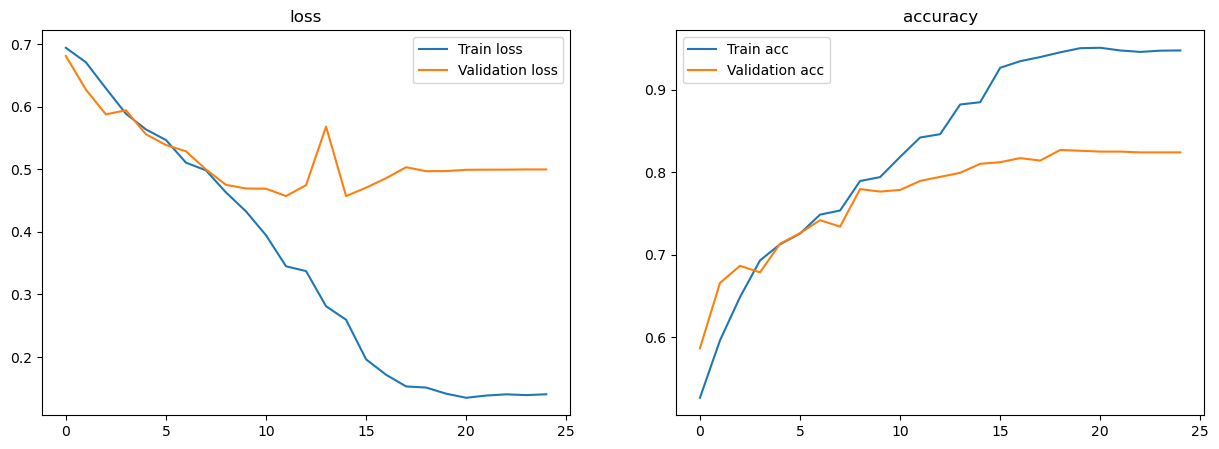

In [37]:
plot_history(history)


## Data Augmentation

![Texte alternatif…](https://cdn-images-1.medium.com/max/1020/1*C8hNiOqur4OJyEZmC7OnzQ.png)

### Second model with Data Augmentation

In [38]:
# We'll use a model with the same convolutional layers, but we'll add Augmentation layers before that

model_2 = Sequential()

model_2.add(layers.Rescaling(1./255, input_shape = (150, 150, 3)))

# Data Augmentation Layers

model_2.add(layers.RandomFlip("horizontal"))
model_2.add(layers.RandomZoom(0.1))
model_2.add(layers.RandomTranslation(0.2, 0.2))
model_2.add(layers.RandomRotation(0.1))


# Convolutional Layers

model_2.add(layers.Conv2D(filters = 32, kernel_size = (3,3), activation="relu", padding = "same"))
model_2.add(layers.MaxPooling2D(pool_size=(2, 2), padding = "same") )


model_2.add(layers.Conv2D(filters = 32, kernel_size = (3,3), input_shape = (150, 150, 3), activation="relu", padding = "same"))
model_2.add(layers.MaxPooling2D(pool_size=(2, 2), padding = "same") )


model_2.add(layers.Conv2D(filters = 64, kernel_size = (3,3), input_shape = (150, 150, 3), activation="relu", padding = "same"))
model_2.add(layers.MaxPooling2D(pool_size=(2, 2), padding = "same") )

model_2.add(layers.Conv2D(filters = 128, kernel_size = (3,3), input_shape = (150, 150, 3), activation="relu", padding = "same"))
model_2.add(layers.MaxPooling2D(pool_size=(2, 2), padding = "same") )

model_2.add(layers.Flatten())

model_2.add(layers.Dense(64, activation="relu"))

model_2.add(layers.Dropout(0.5))

model_2.add(layers.Dense(1, activation="sigmoid"))

In [39]:
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 150, 150, 3)       0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 150, 150, 3)       0         
_________________________________________________________________
random_zoom (RandomZoom)     (None, 150, 150, 3)       0         
_________________________________________________________________
random_translation (RandomTr (None, 150, 150, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 75, 75, 32)       

In [40]:
adam = optimizers.Adam(learning_rate=0.001)

model_2.compile(loss='binary_crossentropy',
              optimizer= adam,
              metrics=['accuracy'])

In [41]:
MODEL = "model_2"

modelCheckpoint = callbacks.ModelCheckpoint("{}.keras".format(MODEL), monitor="val_loss", verbose=0, save_best_only=True)

LRreducer = callbacks.ReduceLROnPlateau(monitor="val_loss", factor = 0.1, patience=3, verbose=1, min_lr=0)

EarlyStopper = callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True)

In [42]:
%%time
history_2 = model_2.fit(
        train_ds,
        epochs=30,
        validation_data=val_ds,
        callbacks = [modelCheckpoint, LRreducer, EarlyStopper]
        )


Epoch 1/30
63/63 [==============================] - 31s 470ms/step - loss: 0.6830 - accuracy: 0.5330 - val_loss: 0.6686 - val_accuracy: 0.5998
Epoch 2/30
63/63 [==============================] - 29s 465ms/step - loss: 0.6686 - accuracy: 0.5719 - val_loss: 0.6571 - val_accuracy: 0.6235
Epoch 3/30
63/63 [==============================] - 29s 452ms/step - loss: 0.6533 - accuracy: 0.6034 - val_loss: 0.6637 - val_accuracy: 0.5731
Epoch 4/30
63/63 [==============================] - 25s 396ms/step - loss: 0.6300 - accuracy: 0.6456 - val_loss: 0.6848 - val_accuracy: 0.6107
Epoch 5/30
63/63 [==============================] - 28s 443ms/step - loss: 0.6197 - accuracy: 0.6489 - val_loss: 0.6203 - val_accuracy: 0.6808
Epoch 6/30
63/63 [==============================] - 29s 452ms/step - loss: 0.6065 - accuracy: 0.6708 - val_loss: 0.7207 - val_accuracy: 0.5702
Epoch 7/30
63/63 [==============================] - 28s 451ms/step - loss: 0.6230 - accuracy: 0.6546 - val_loss: 0.5663 - val_accuracy: 0.7045

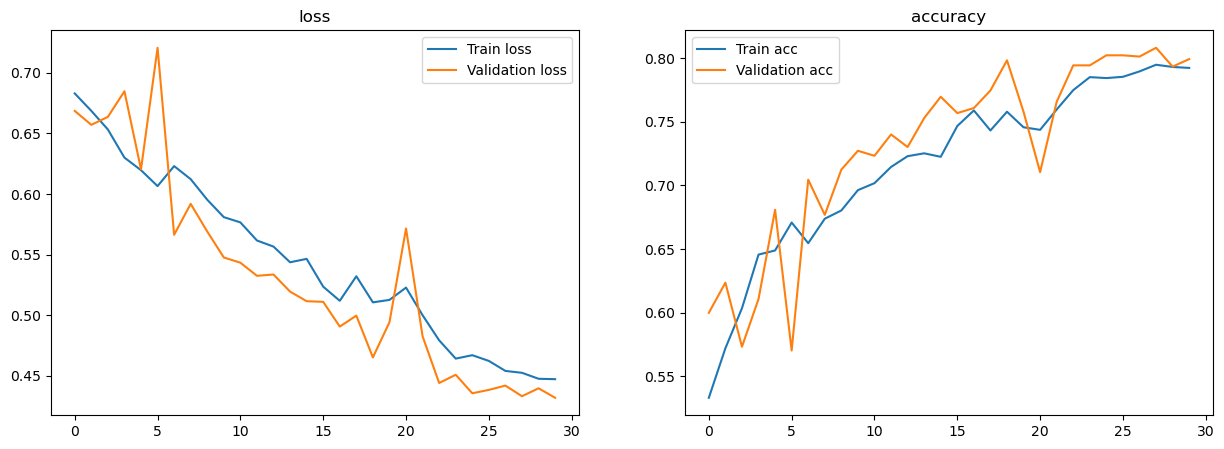

In [43]:
plot_history(history_2)

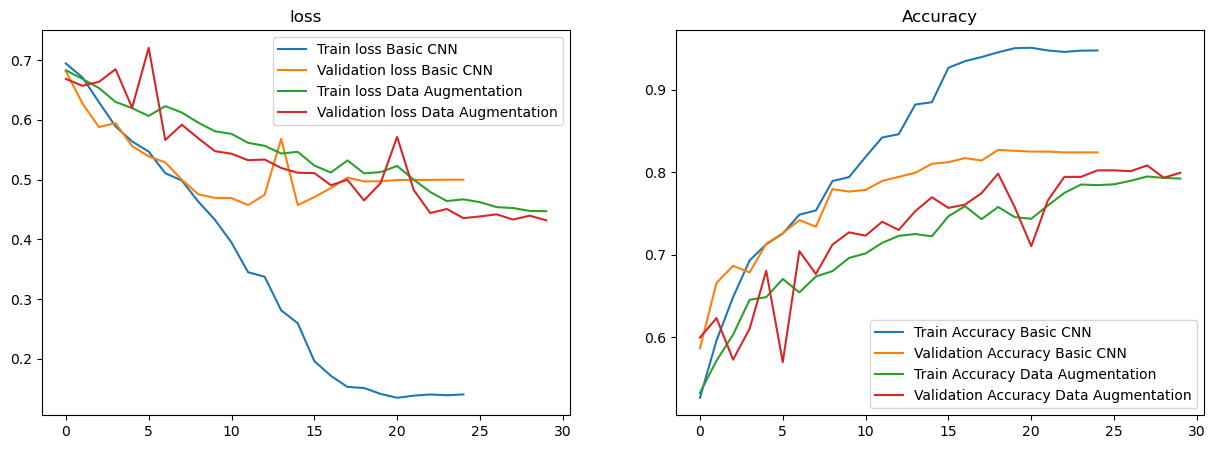

In [44]:
plot_compare_history(history, "Basic CNN", history_2, "Data Augmentation")

## Transfer Learning

![Texte alternatif…](https://cdn-images-1.medium.com/max/1600/1*9GTEzcO8KxxrfutmtsPs3Q.png)

![Texte alternatif…](https://www.researchgate.net/profile/Francesco-Orabona/publication/221363182/figure/fig1/AS:276504308142080@1442935172550/Three-ways-in-which-transfer-might-improve-learning-19.png)

### Third model with Transfer Learning and Data Augmentation

In [45]:
data_augmentation = Sequential()

data_augmentation.add(layers.RandomFlip("horizontal"))
data_augmentation.add(layers.RandomZoom(0.1))
data_augmentation.add(layers.RandomTranslation(0.2, 0.2))
data_augmentation.add(layers.RandomRotation(0.1))

In [46]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model

In [47]:
base_model = VGG16(weights = "imagenet", include_top = False, input_shape = (150, 150, 3))

58900480/58889256 [==============================] - 3s 0us/step


In [48]:
# First step is to initialize the VGG16 model but without the top as we'll adapt it to our problem

inputs = layers.Input(shape = (150, 150, 3))

x = data_augmentation(inputs) # We still have our data augmentation layers
x = preprocess_input(x) # Then a preprocessing layer specifically designed for the VGG16
x = base_model(x) # Then our transfer learning model

x = layers.Flatten()(x) # Followed by our custom dense layers, tailored to our binary task

x = layers.Dense(128, activation = "relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation = "relu")(x)
x = layers.Dropout(0.3)(x)
pred = layers.Dense(1, activation = "sigmoid")(x)

# We use the keras Functional API to create our keras model

model_3 = Model(inputs = inputs , outputs = pred)

# And we freeze the VGG16 model

base_model.trainable = False

#for layer in base_model.layers[:10]:
#  layer.trainable = False


In [49]:
model_3.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 150, 150, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 150, 150, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 150, 150, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               104870

In [50]:
adam = optimizers.Adam(learning_rate = 0.001)
model_3.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

In [51]:
MODEL = "model_3"

modelCheckpoint = callbacks.ModelCheckpoint("{}.keras".format(MODEL), monitor="val_loss", verbose=0, save_best_only=True)

LRreducer = callbacks.ReduceLROnPlateau(monitor="val_loss", factor = 0.1, patience=3, verbose=1, min_lr=0)

EarlyStopper = callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True)


In [52]:
%%time
history_3 = model_3.fit(
        train_ds,
        epochs=30,
        validation_data=val_ds,
        callbacks = [modelCheckpoint, LRreducer, EarlyStopper])

Epoch 1/30
63/63 [==============================] - 102s 2s/step - loss: 1.2364 - accuracy: 0.8412 - val_loss: 0.2209 - val_accuracy: 0.9644
Epoch 2/30
63/63 [==============================] - 99s 2s/step - loss: 0.3658 - accuracy: 0.8951 - val_loss: 0.1760 - val_accuracy: 0.9565
Epoch 3/30
63/63 [==============================] - 101s 2s/step - loss: 0.2510 - accuracy: 0.8984 - val_loss: 0.1587 - val_accuracy: 0.9565
Epoch 4/30
63/63 [==============================] - 111s 2s/step - loss: 0.2297 - accuracy: 0.9153 - val_loss: 0.1472 - val_accuracy: 0.9615
Epoch 5/30
63/63 [==============================] - 134s 2s/step - loss: 0.2073 - accuracy: 0.9208 - val_loss: 0.1602 - val_accuracy: 0.9713
Epoch 6/30
63/63 [==============================] - 99s 2s/step - loss: 0.2029 - accuracy: 0.9278 - val_loss: 0.1215 - val_accuracy: 0.9664
Epoch 7/30
63/63 [==============================] - 118s 2s/step - loss: 0.1940 - accuracy: 0.9233 - val_loss: 0.1152 - val_accuracy: 0.9753
Epoch 8/30
63/6

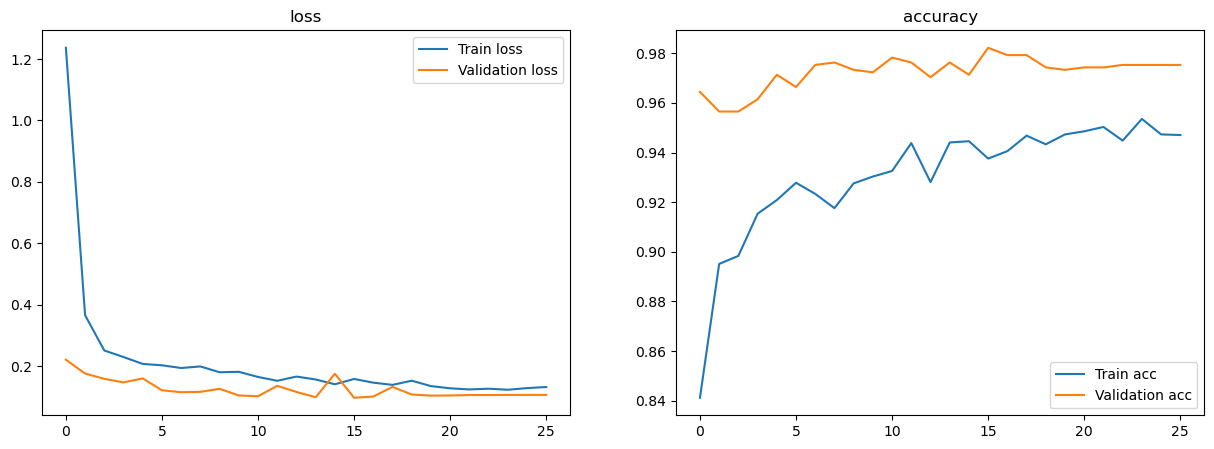

In [53]:
plot_history(history_3)

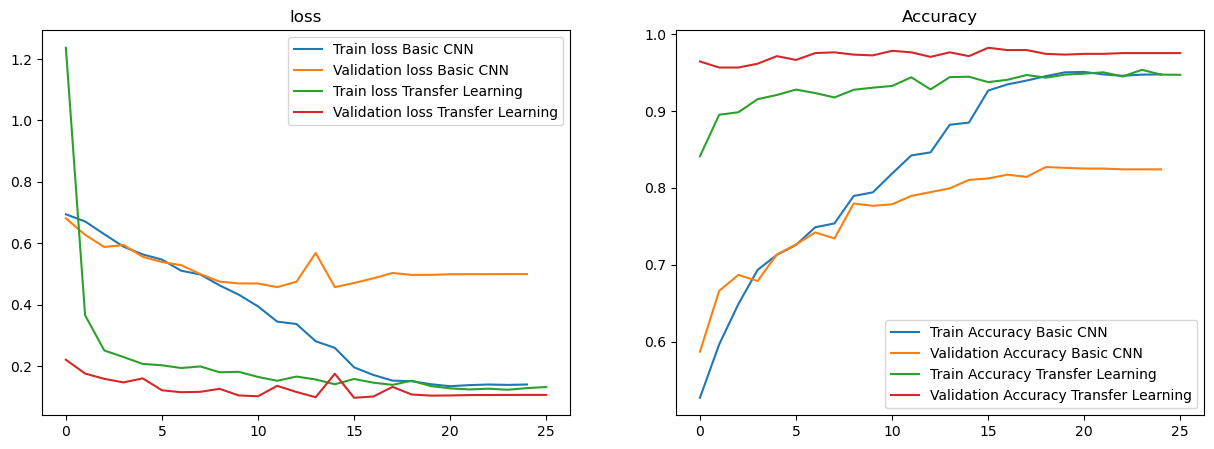

In [54]:
plot_compare_history(history, "Basic CNN", history_3, "Transfer Learning")

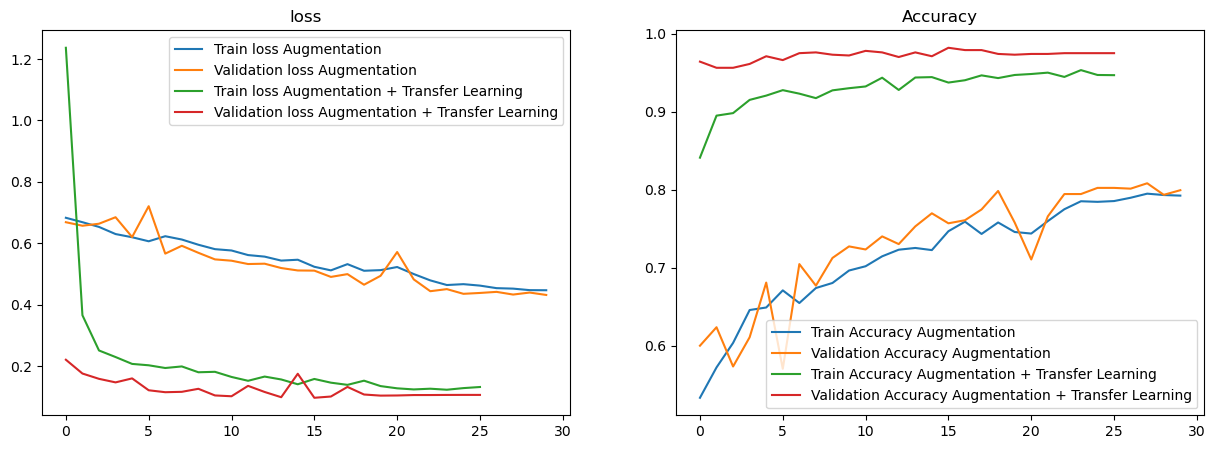

In [55]:
plot_compare_history(history_2, "Augmentation", history_3, "Augmentation + Transfer Learning")

## Save and use the model

In [56]:
model_3.save("model_3.keras")

In [57]:
from tensorflow.keras.models import load_model

model_3 = load_model("model_3.keras")

In [58]:
from PIL import Image
import requests
from io import BytesIO

def getImage(url):

  # Grabs an image based on its URL, and resize it

  response = requests.get(url)
  img = Image.open(BytesIO(response.content))
  plt.imshow(img)
  img = img.resize((150, 150))
  return img

def predictImage(url, model):

  # Takes an imafe and a model

  img = getImage(url)
  img = img_to_array(img)
  img = img.reshape((-1, 150, 150, 3))
  res = model.predict(img)[0][0]
  if(res < 0.5):
    animal = "cat"
    prob = 1-res
  if(res >= 0.5):
    animal = "dog"
    prob = res

  print("Animal : ", animal)
  print("probability = ",prob)

In [59]:
cat = "https://www.wikichat.fr/wp-content/uploads/sites/2/comment-soigner-une-plaie-dun-chat.jpg"
cat2 = "http://create.votreveterinaire.com/adm/webmaster/_empty/upload/chat_surpris.jpg"


dog = "https://images.sudouest.fr/2018/04/14/5ace461a66a4bd2b1780a0dd/widescreen/1000x500/on-ignore-si-le-chihuahua-a-deserte-ou-non-les-locaux-de-la-clinique.jpg?v1"
dog2 = "https://ds1.static.rtbf.be/article/image/370x208/7/8/f/a20f02dfccd07952da54a7f9a82b3e89-1524657315.jpg"

In [60]:
predictImage(cat, model_3)

UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x0000027DDD74DC70>

In [61]:
predictImage(cat2, model_3)

ConnectionError: ('Connection aborted.', ConnectionResetError(10054, 'Eine vorhandene Verbindung wurde vom Remotehost geschlossen', None, 10054, None))

Animal :  dog
probability =  0.9964216


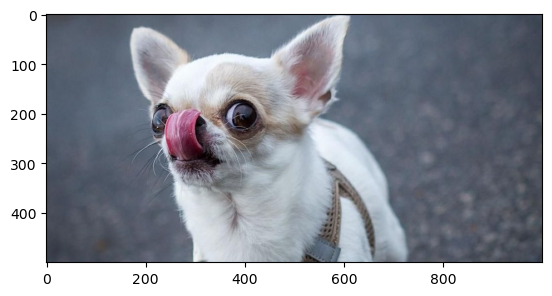

In [62]:
predictImage(dog, model_3)

Animal :  dog
probability =  1.0


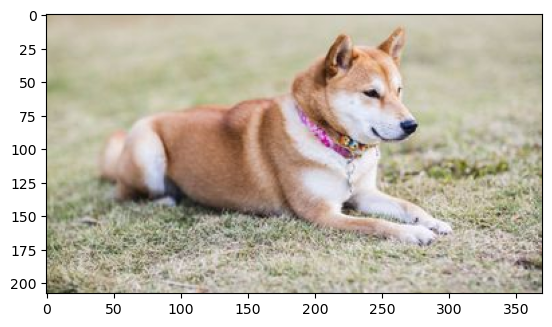

In [63]:
predictImage(dog2, model_3)